# Exploring the data collected by HealthKit

### Exporting the data
In the Health App hit your profile, then the "Export all Health Data" button. AirDrop the zip to your computer in a directory you can use then unzip using `unzip export.zip`

In [1]:
!tree apple_health_export
# !pip install bokeh

apple_health_export
├── export.xml
├── export_cda.xml
└── workout-routes
    ├── route_2019-08-13_11.27am.gpx
    ├── route_2019-08-18_9.35am.gpx
    ├── route_2019-08-26_4.05pm.gpx
    ├── route_2019-09-04_3.57pm.gpx
    ├── route_2019-09-08_1.47pm.gpx
    ├── route_2019-09-11_4.37pm.gpx
    ├── route_2019-09-16_4.44pm.gpx
    ├── route_2019-09-23_10.32am.gpx
    ├── route_2019-09-23_3.38pm.gpx
    └── route_2019-10-29_5.09pm.gpx

1 directory, 12 files


In [2]:
import pandas as pd
import xmltodict
import json
import pickle
import numpy as np

In [3]:
def read_file(name):
    with open(name) as f:
        contents = f.read()
    
    xml = xmltodict.parse(contents)
    return xml

health = read_file("apple_health_export/export.xml")
clinical = read_file("apple_health_export/export_cda.xml")

In [4]:
# for k in health["HealthData"].keys():
#     print(k)

# ActivitySummary

In [5]:
def parse_file(xml):
    health_data = xml["HealthData"]
    for key in health_data.keys():
        with open(f"pkl/{str(key)}.pkl", 'wb') as f:
            pickle.dump(health_data[key], f)
    

parse_file(health)
# parse_file(clinical)

In [6]:
def flatten_nested(df, nested):
    df = df.copy()
    meta = pd.DataFrame()
    
    for i, array in enumerate(df[nested].values):
        d = {}
        if type(array) is list:
            for ord_dict in array:
                d[ord_dict['@key']] = ord_dict['@value']
        elif type(array) is float:
            d[''] = ''
        else:
            # contains only key and value
            d[array['@key']] = array['@value']
        meta = meta.append(d, ignore_index=True)
    return pd.concat([df, meta], axis=1)

def convertColumn(name, col):
    if "date" in name.lower():
        # I can't find any documentation on the "-1000" so I am just removing it :)
        return col.str.strip("-1000").astype("datetime64[ns]")
    if "value" in name.lower():
        return pd.to_numeric(col, errors='coerce')
    return pd.to_numeric(col, errors='ignore')

def data_cleaning(dataframe, nested_column, flatten = True):
    if flatten:        
        dataframe = flatten_nested(dataframe, nested_column)
        
    for c in dataframe:
        dataframe[c] = convertColumn(c, dataframe[c])
    dataframe.columns = dataframe.columns.str.replace('@','')
    return dataframe


In [7]:
with open("pkl/Workout.pkl", 'rb') as f:
    Workout = pd.DataFrame(pickle.load(f))
    workout_df = data_cleaning(Workout, 'MetadataEntry')
    # Oi looks like we have an outlier (forgot to stop a workout recording for 20hours)
    workout_df = workout_df.drop(162)

In [8]:
with open("pkl/ActivitySummary.pkl", 'rb') as f:
    Activity = pd.DataFrame(pickle.load(f))
    # this data set doesn't need much cleaning :)
    Activity.columns = Activity.columns.str.replace('@','')
    activity_df = Activity

In [9]:
with open("pkl/Record.pkl", 'rb') as f:
    Record = pd.DataFrame(pickle.load(f))
    record_df = data_cleaning(Record, 'MetadataEntry', flatten=False)

In [10]:
# Record.info(memory_usage='deep')
# pd.to_numeric(record_df.value)

types = record_df.type.unique()
print(types)
record_df[record_df.type == 'HKQuantityTypeIdentifierHeadphoneAudioExposure']

['HKQuantityTypeIdentifierHeight' 'HKQuantityTypeIdentifierBodyMass'
 'HKQuantityTypeIdentifierHeartRate' 'HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierDistanceWalkingRunning'
 'HKQuantityTypeIdentifierBasalEnergyBurned'
 'HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierFlightsClimbed'
 'HKQuantityTypeIdentifierAppleExerciseTime'
 'HKQuantityTypeIdentifierRestingHeartRate'
 'HKQuantityTypeIdentifierVO2Max'
 'HKQuantityTypeIdentifierWalkingHeartRateAverage'
 'HKQuantityTypeIdentifierHeadphoneAudioExposure'
 'HKQuantityTypeIdentifierAppleStandTime'
 'HKCategoryTypeIdentifierSleepAnalysis'
 'HKCategoryTypeIdentifierAppleStandHour'
 'HKCategoryTypeIdentifierMenstrualFlow'
 'HKCategoryTypeIdentifierMindfulSession'
 'HKCategoryTypeIdentifierMenstrualSymptomAbdominalCramps'
 'HKCategoryTypeIdentifierMenstrualSymptomBreastTenderness'
 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN']


,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device,MetadataEntry,HeartRateVariabilityMetadataList
296370,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 13:40:11,2019-10-05 13:29:10,2019-10-05 13:29:58,59.5189,"<<HKDevice: 0x2810340f0>, name:AirPods, manufa...",NaN,NaN
296371,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 13:40:11,2019-10-05 13:30:10,2019-10-05 13:30:28,52.5914,"<<HKDevice: 0x2810348c0>, name:AirPods, manufa...",NaN,NaN
296372,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 13:49:43,2019-10-05 13:31:05,2019-10-05 13:45:40,64.7769,"<<HKDevice: 0x281034640>, name:AirPods, manufa...",NaN,NaN
296373,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 14:38:28,2019-10-05 13:46:36,2019-10-05 13:49:17,57.1529,"<<HKDevice: 0x281034780>, name:AirPods, manufa...",NaN,NaN
296374,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 14:38:28,2019-10-05 13:49:17,2019-10-05 13:49:39,61.4959,"<<HKDevice: 0x2810347d0>, name:AirPods, manufa...",NaN,NaN
296375,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 14:38:28,2019-10-05 13:49:54,2019-10-05 14:19:51,57.6844,"<<HKDevice: 0x281034460>, name:AirPods, manufa...",NaN,NaN
296376,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 14:39:26,2019-10-05 14:19:51,2019-10-05 14:38:28,57.4064,"<<HKDevice: 0x2810341e0>, name:AirPods, manufa...",NaN,NaN
296377,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 14:49:55,2019-10-05 14:38:28,2019-10-05 14:41:17,59.4999,"<<HKDevice: 0x281034cd0>, name:AirPods, manufa...",NaN,NaN
296378,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 14:59:30,2019-10-05 14:41:17,2019-10-05 14:49:21,57.6270,"<<HKDevice: 0x281034e10>, name:AirPods, manufa...",NaN,NaN
296379,HKQuantityTypeIdentifierHeadphoneAudioExposure,Cassie’s iPhone,13.0,dBASPL,2019-10-05 14:59:30,2019-10-05 14:49:21,2019-10-05 14:49:45,58.1796,"<<HKDevice: 0x281034f50>, name:AirPods, manufa...",NaN,NaN


In [11]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

(Timestamp('2019-10-05 13:29:10'), Timestamp('2019-11-18 12:52:46'))

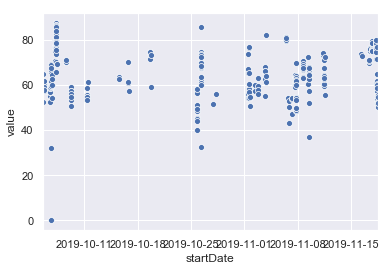

In [12]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

audio = record_df[record_df.type == 'HKQuantityTypeIdentifierHeadphoneAudioExposure']
plt.xlim(pd.to_datetime('2019-10-05 13:29:10'), pd.to_datetime('2019-11-18 12:52:46'))
ax = sns.scatterplot(x="startDate", y="value", data=audio)
audio.startDate.min(), audio.startDate.max()
# plt.xlim(pd.to_datetime('2019-10-05 13:29:10'), pd.to_datetime('2019-11-18 12:52:46'))


In [13]:
audio.startDate.min(), audio.startDate.max()


(Timestamp('2019-10-05 13:29:10'), Timestamp('2019-11-18 12:52:46'))

In [68]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import matplotlib.pyplot as plt

from bokeh.models import  ColumnDataSource, Range1d, LabelSet, Label
from bokeh.palettes import Spectral10


def pretty_graph(df, x, y, x_label, y_label, title):
        
    source_df = ColumnDataSource(data={
            'duration': df[x],
            'totalEnergyBurned': df[y],
            'workoutActivityType': df["workoutActivityType"]
    })
    
    # cant figure out why this stupid thing isnt working
    #source_df = ColumnDataSource(data=workout_df)
    TOOLTIPS = "Burned $y calories in $x minutes doing @workoutActivityType"  
    p = figure(
            plot_width=800, plot_height=1000, 
            x_axis_label=x_label,
            y_axis_label=y_label,
            title=title,
            tools='hover', 
            tooltips=TOOLTIPS
    )
        
    index_cmap = factor_cmap('workoutActivityType', palette=Spectral10, 
                         factors=sorted(df.workoutActivityType.unique()))
    p.scatter("duration", "totalEnergyBurned", source = source_df, fill_alpha=0.6, fill_color=index_cmap, size=10, legend_field='workoutActivityType')
    
    return p


# show the results
output_notebook()
p = pretty_graph(workout_df, "duration", "totalEnergyBurned", 'Duration', "Calories Burned", "Duration of exercise correlated versus calories burned?")

# p.xgrid.grid_line_color = None
show(p)
# print(source_df.data)

Loading BokehJS ...

In [63]:
# source_df.data['duration']

In [15]:
workout_df.iloc[163]

workoutActivityType                             HKWorkoutActivityTypeDance
duration                                                           118.537
durationUnit                                                           min
totalDistance                                                      2.67855
totalDistanceUnit                                                       mi
totalEnergyBurned                                                  596.374
totalEnergyBurnedUnit                                                 kcal
sourceName                                         Cassandra’s Apple Watch
sourceVersion                                                        5.2.1
device                   <<HKDevice: 0x2813eec60>, name:Apple Watch, ma...
creationDate                                           2019-06-28 09:01:39
startDate                                              2019-06-28 07:02:52
endDate                                                2019-06-28 09:01:24
MetadataEntry            

In [16]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors

output_notebook()

def colors_from_categories(categories):
    colors = [
        "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*cm.viridis(mplcolors.Normalize()(range(0,10)))
    ]
    
    d = {}
    for i, c in enumerate(categories):
        d[c] = colors[i]
    return d

color_dict = colors_from_categories(workout_df.workoutActivityType.unique())
color = [color_dict[x] for x in workout_df.workoutActivityType]

def pretty_graph(df, x, y, x_label, y_label, title):
        TOOLTIPS = "Burned $y calories in $x minutes"
        
        p = figure(
            plot_width=400, plot_height=400, 
            x_axis_label=x_label,
            y_axis_label=y_label,
            title=title,
            tools='hover,wheel_zoom', 
            tooltips=TOOLTIPS
        )

        # add a circle renderer with a size, color, and alpha
        p.circle(df[x], df[y], size=10, 
                 color=color, alpha=0.5
                 #, legend_field=df.workoutActivityType.uniqu
                )
    
        return p


# show the results

p = pretty_graph(workout_df, "duration", "totalEnergyBurned", 'Duration', "Calories Burned", "Duration of exercise correlated versus calories burned?")

p.xgrid.grid_line_color = None
# p.legend.orientation = "horizontal"
# p.legend.location = "top_center"

show(p)

# Todo get the entry by index workout_df.iloc[143]

Loading BokehJS ...